In [ ]:
#upload kaggle.json
from google.colab import files
files.upload()

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d andrewmvd/dog-and-cat-detection

In [ ]:
!unzip /content/dog-and-cat-detection.zip

In [ ]:
!pip install imagehash

In [ ]:
import torch, torchvision
import glob
import os
import numpy as np
import cv2
import random
import itertools
import pandas as pd
import urllib
import json
import PIL.Image as Image
import shutil
from os.path import exists
from tqdm.auto import  tqdm
import imagehash


anno_path = "/content/annotations/"
image_path = "/content/images/"

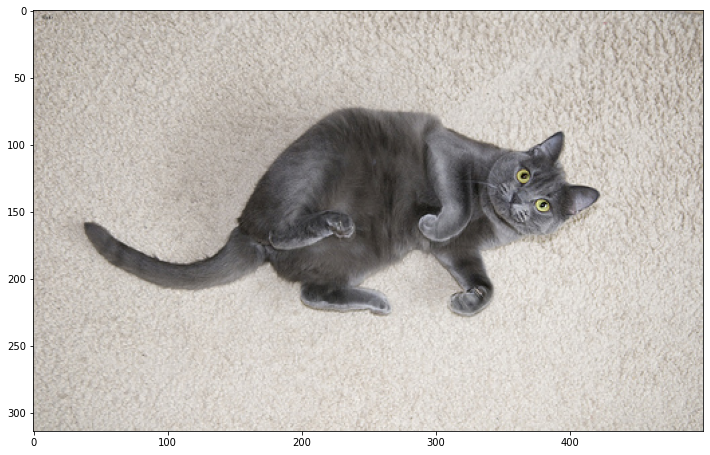

In [ ]:
import matplotlib.pyplot as plt
#trying it out on a sample image
img = cv2.imread('/content/images/Cats_Test1040.png')

img = cv2.cvtColor(img,  cv2.COLOR_RGB2BGR)

plt.figure(figsize=(12,12))
plt.imshow(img)

In [ ]:
!pip install xmltodict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
xml_names = []
img_names = []

xml_names = [ f for f in os.listdir(anno_path) if os.path.isfile(os.path.join(anno_path,f)) ]
img_names = [ f for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path,f)) ]

In [ ]:
from collections import Counter
import xmltodict

path_annotations="/content/annotations/" 
listing=[]
for i in img_names[:]:
    with open(path_annotations+i[:-4]+".xml") as fd:
        doc=xmltodict.parse(fd.read())
    temp=doc["annotation"]["object"]
    if type(temp)==list:
        for i in range(len(temp)):
            listing.append(temp[i]["name"])
    else:
        listing.append(temp["name"])
        

Items = Counter(listing).keys()
values = Counter(listing).values()

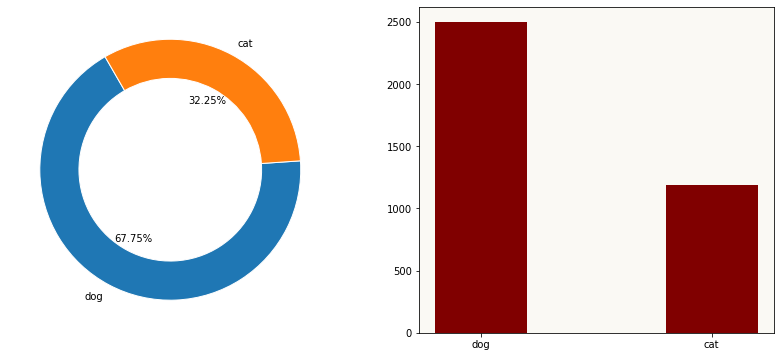

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(14,6))
background_color = '#faf9f4'
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color) 
ax1.pie(values,wedgeprops=dict(width=0.3, edgecolor='w') ,
        labels=Items, radius=1, startangle = 120, autopct='%1.2f%%')

ax2 = plt.bar(Items, list(values),
              color ='maroon',width = 0.4)

plt.show()

the dataset is unbalanced, it is necessary to trim it or add augmentation

In [ ]:
funcs = [
        imagehash.average_hash,
        imagehash.phash,
        imagehash.dhash,
        imagehash.whash,
    ]
image_ids = []
hashes = []

for path in tqdm(glob.glob(image_path + '*.png' )):
    image = Image.open(path)
    image_id = os.path.basename(path)
    image_ids.append(image_id)
    hashes.append(np.array([f(image).hash for f in funcs]).reshape(256))

hashes_all = np.array(hashes)

  0%|          | 0/3686 [00:00<?, ?it/s]

In [ ]:
hashes_all = torch.Tensor(hashes_all.astype(int)).cuda()

In [ ]:
sims = np.array([(hashes_all[i] == hashes_all).sum(dim=1).cpu().numpy()/256 for i in range(hashes_all.shape[0])])

In [ ]:
indices1 = np.where(sims > 0.9)
indices2 = np.where(indices1[0] != indices1[1])
image_ids1 = [image_ids[i] for i in indices1[0][indices2]]
image_ids2 = [image_ids[i] for i in indices1[1][indices2]]
dups = {tuple(sorted([image_id1,image_id2])):True for image_id1, image_id2 in zip(image_ids1, image_ids2)}

print('found %d duplicates' % len(dups))

found 34 duplicates


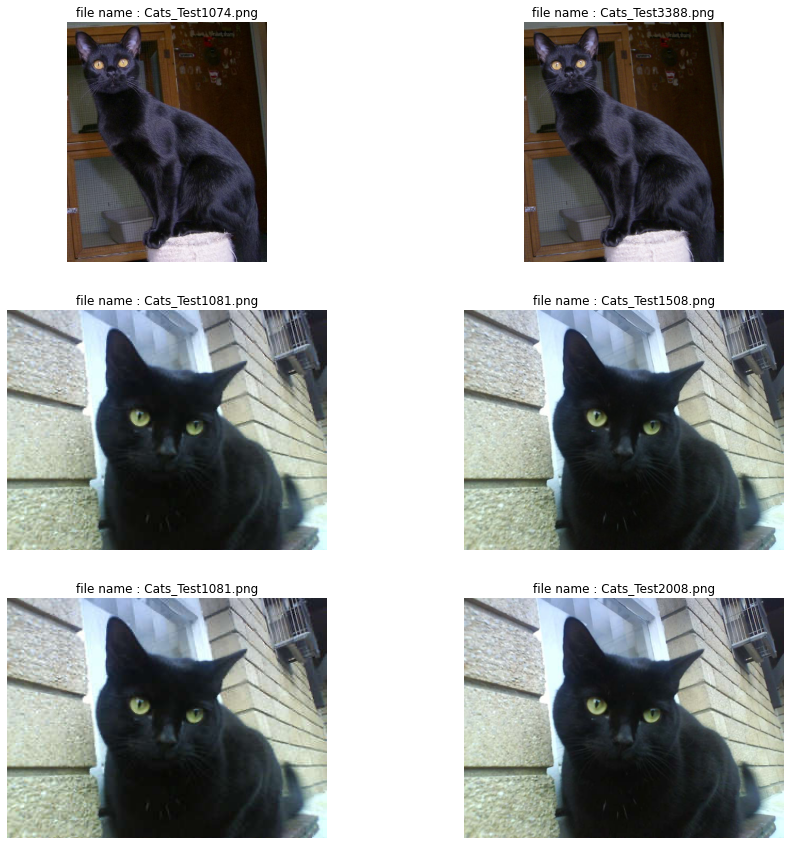

In [ ]:
duplicate_image_ids = sorted(list(dups))

fig, axs = plt.subplots(3, 2, figsize=(15,15))

for row in range(3):
        for col in range(2):
            img_id = duplicate_image_ids[row][col]
            img = Image.open(image_path + img_id)
            axs[row, col].imshow(img)
            axs[row, col].set_title("file name : "+ img_id)
            axs[row, col].axis('off')

In [ ]:
img_duplicates = []
for image_dup in duplicate_image_ids:
    img_duplicates.append(image_dup[0])

In [ ]:
xml_duplicates = [name.replace('png', 'xml') for name in img_duplicates]

In [ ]:
xmlfiles = []
imgfiles = []

xmlfiles = [ f for f in os.listdir(anno_path) if os.path.isfile(os.path.join(anno_path,f)) ]
xmlfiles = sorted(xmlfiles)

imgfiles = [ f for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path,f)) ]
imgfiles = sorted(imgfiles)

print(xmlfiles[0:3])
print(imgfiles[0:3])

assert len(xmlfiles) == len(imgfiles)

['Cats_Test0.xml', 'Cats_Test1.xml', 'Cats_Test10.xml']
['Cats_Test0.png', 'Cats_Test1.png', 'Cats_Test10.png']


In [ ]:
imgfiles = [img for img in imgfiles if img not in img_duplicates]
xmlfiles = [xml for xml in xmlfiles if xml not in xml_duplicates]

assert len(xmlfiles) == len(imgfiles)

In [ ]:
import random

temp = list(zip(xmlfiles, imgfiles))
random.shuffle(temp)
xmlfiles, imgfiles = zip(*temp)

print(xmlfiles[0:3])
print(imgfiles[0:3])

('Cats_Test2086.xml', 'Cats_Test1863.xml', 'Cats_Test1029.xml')
('Cats_Test2086.png', 'Cats_Test1863.png', 'Cats_Test1029.png')


In [ ]:
if not exists('./cat_dog_detection/'):
    os.makedirs('./cat_dog_detection/')
    if not exists('./cat_dog_detection/train/'):
        os.makedirs('./cat_dog_detection/train/')
        os.makedirs('./cat_dog_detection/train/images')
        os.makedirs('./cat_dog_detection/train/annotations')
        print('train directory created')
    else:
        print('train directory already exists')

train directory created


In [ ]:
if not exists('./cat_dog_detection/test/'):
    os.makedirs('./cat_dog_detection/test/')
    os.makedirs('./cat_dog_detection/test/images')
    os.makedirs('./cat_dog_detection/test/annotations')
    print('test directory created')
else:
    print('test directory already exists')

test directory created


In [ ]:
test_ratio = 0.20

train_img, test_img = np.split(np.array(imgfiles), [int(len(imgfiles)* (1 - test_ratio))])
print(train_img[0])
print(test_img[0:3])

train_xml, test_xml = np.split(np.array(xmlfiles), [int(len(xmlfiles)* (1 - test_ratio))])
print(train_xml[0])
print(test_xml[0])

Cats_Test2086.png
['Cats_Test2808.png' 'Cats_Test1340.png' 'Cats_Test3258.png']
Cats_Test2086.xml
Cats_Test2808.xml


In [ ]:
print(len(train_img) + len(test_img))

3654


In [ ]:
train_imgs = []
test_imgs = []

train_imgs = [image_path + '/' + name for name in train_img]
test_imgs = [image_path + '/' + name for name in test_img]
print(train_imgs[0])
print(test_imgs[0])

/content/images//Cats_Test2086.png
/content/images//Cats_Test2808.png


In [ ]:
train_xmls = []
test_xmls = []

train_xmls = [anno_path + '/' + name for name in train_xml.tolist()]
test_xmls = [anno_path + '/' + name for name in test_xml.tolist()]
print(train_xmls[0])
print(test_xmls[0])

/content/annotations//Cats_Test2086.xml
/content/annotations//Cats_Test2808.xml


In [ ]:
for name in train_imgs:
  shutil.copy(name, './cat_dog_detection/train/images')

for name in test_imgs:
  shutil.copy(name, './cat_dog_detection/test/images')

In [ ]:
for name in train_xmls:
  shutil.copy(name, './cat_dog_detection/train/annotations')

for name in test_xmls:
  shutil.copy(name, './cat_dog_detection/test/annotations')

In [ ]:
%%writefile train_xml_list.txt
Hello, this is a test file.

Writing train_xml_list.txt


In [ ]:
with open('./train_xml_list.txt', 'w') as f:
    for item in train_xml:
        f.write("%s\n" % item)

In [ ]:
%%writefile cat_dog_detection/train/train_annotations.json
Hello, this is a test file.

Writing cat_dog_detection/train/train_annotations.json


In [ ]:
%%writefile test_xml_list.txt
Hello, this is a test file.

Writing test_xml_list.txt


In [ ]:
with open('./test_xml_list.txt', 'w') as f:
    for item in test_xml:
        f.write("%s\n" % item)

In [ ]:
%%writefile cat_dog_detection/test/test_annotations.json
Hello, this is a quick file.

Writing cat_dog_detection/test/test_annotations.json


In [ ]:
!pip install lxml

import sys
import os
import json
import xml.etree.ElementTree as ET


START_BOUNDING_BOX_ID = 1
PRE_DEFINE_CATEGORIES = {}


def get(root, name):
    vars = root.findall(name)
    return vars


def get_and_check(root, name, length):
    vars = root.findall(name)
    if len(vars) == 0:
        raise NotImplementedError('Can not find %s in %s.'%(name, root.tag))
    if length > 0 and len(vars) != length:
        raise NotImplementedError('The size of %s is supposed to be %d, but is %d.'%(name, length, len(vars)))
    if length == 1:
        vars = vars[0]
    return vars


def get_filename_as_int(filename):
    try:
        filename = os.path.splitext(filename)[0]
        return filename
    except:
        raise NotImplementedError('Filename %s is supposed to be an integer.'%(filename))


def convert(xml_list, xml_dir, json_file):
    list_fp = open(xml_list, 'r')
    json_dict = {"images":[], "type": "instances", "annotations": [],
                 "categories": []}
    categories = PRE_DEFINE_CATEGORIES
    bnd_id = START_BOUNDING_BOX_ID
    for line in list_fp:
        line = line.strip()
        #print("Processing %s"%(line))
        xml_f = os.path.join(xml_dir, line)
        tree = ET.parse(xml_f)
        root = tree.getroot()
        path = get(root, 'path')
        if len(path) == 1:
            filename = os.path.basename(path[0].text)
        elif len(path) == 0:
            filename = get_and_check(root, 'filename', 1).text
        else:
            raise NotImplementedError('%d paths found in %s'%(len(path), line))
        image_id = get_filename_as_int(filename)
        size = get_and_check(root, 'size', 1)
        width = int(get_and_check(size, 'width', 1).text)
        height = int(get_and_check(size, 'height', 1).text)
        image = {'file_name': filename, 'height': height, 'width': width,
                 'id':image_id}
        json_dict['images'].append(image)
        ## Cruuently we do not support segmentation
        #  segmented = get_and_check(root, 'segmented', 1).text
        #  assert segmented == '0'
        for obj in get(root, 'object'):
            category = get_and_check(obj, 'name', 1).text
            if category not in categories:
                new_id = len(categories)
                categories[category] = new_id
            category_id = categories[category]
            bndbox = get_and_check(obj, 'bndbox', 1)
            xmin = int(get_and_check(bndbox, 'xmin', 1).text) - 1
            ymin = int(get_and_check(bndbox, 'ymin', 1).text) - 1
            xmax = int(get_and_check(bndbox, 'xmax', 1).text)
            ymax = int(get_and_check(bndbox, 'ymax', 1).text)
            assert(xmax > xmin)
            assert(ymax > ymin)
            o_width = abs(xmax - xmin)
            o_height = abs(ymax - ymin)
            ann = {'area': o_width*o_height, 'iscrowd': 0, 'image_id':
                   image_id, 'bbox':[xmin, ymin, o_width, o_height],
                   'category_id': category_id, 'id': bnd_id, 'ignore': 0,
                   'segmentation': []}
            json_dict['annotations'].append(ann)
            bnd_id = bnd_id + 1

    for cate, cid in categories.items():
        cat = {'supercategory': 'none', 'id': cid, 'name': cate}
        json_dict['categories'].append(cat)
    json_fp = open(json_file, 'w')
    json_str = json.dumps(json_dict)
    json_fp.write(json_str)
    json_fp.close()
    list_fp.close()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
convert('train_xml_list.txt', './cat_dog_detection/train/annotations/', './cat_dog_detection/train/train_annotations.json')

In [ ]:
convert('test_xml_list.txt', './cat_dog_detection/test/annotations', './cat_dog_detection/test/test_annotations.json')

# So, let's train the model!


In [ ]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

# Check Pytorch installation
import torch
print(torch.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

1.12.0+cu113


In [ ]:
!python -m pip install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 7.1 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3


In [ ]:
!pip install openmim --use-feature=2020-resolver
!mim install mmdet

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -r requirements/build.txt 
!pip install -v -e . 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 7.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.12.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.2/190.2 kB 20.5 MB/s eta 0:00:00
Cloning into 'mmdetection'...
remote: Enumerating objects: 29025, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 29025 (delta 39), reused 70 (delta 29), pack-reuse

In [ ]:
from mmcv import collect_env
collect_env()

{'CUDA available': True,
 'CUDA_HOME': '/usr/local/cuda',
 'GCC': 'x86_64-linux-gnu-gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0',
 'GPU 0': 'Tesla T4',
 'MMCV': '1.6.1',
 'MMCV CUDA Compiler': '11.3',
 'MMCV Compiler': 'GCC 9.3',
 'NVCC': 'Cuda compilation tools, release 11.1, V11.1.105',
 'OpenCV': '4.6.0',
 'PyTorch': '1.12.0+cu113',
 'PyTorch compiling details': 'PyTorch built with:\n  - GCC 9.3\n  - C++ Version: 201402\n  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications\n  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)\n  - OpenMP 201511 (a.k.a. OpenMP 4.5)\n  - LAPACK is enabled (usually provided by MKL)\n  - NNPACK is enabled\n  - CPU capability usage: AVX2\n  - CUDA Runtime 11.3\n  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gen

In [ ]:
# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

2.25.1
11.3
GCC 9.3


In [ ]:
#parse the order of categories in the json file
import json

with open('.././cat_dog_detection/train/train_annotations.json', 'r') as json_file:
    json_load = json.load(json_file)

CLASSES = []
for i in range(2):
    #print(json_load['categories'][i]['name'])
    CLASSES.append(json_load['categories'][i]['name'])

print(CLASSES)

['cat', 'dog']


In [ ]:
if not exists('./workdirs'):
    os.makedirs('./workdirs')

In [ ]:
from mmcv import Config
cfg = Config.fromfile('/content/mmdetection/configs/empirical_attention/faster_rcnn_r50_fpn_attention_0010_dcn_1x_coco.py')

In [ ]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.data_root = '/content/cat_dog_detection/'

cfg.data.test.classes = (CLASSES[0], CLASSES[1])
cfg.data.test.ann_file = cfg.data_root + 'train/train_annotations.json'
cfg.data.test.img_prefix = cfg.data_root + 'train/images/'

cfg.data.val.classes = (CLASSES[0], CLASSES[1])
cfg.data.val.ann_file = cfg.data_root + 'test/test_annotations.json'
cfg.data.val.img_prefix = cfg.data_root + 'test/images/'

## modify the training process
cfg.img_norm_cfg = dict(mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.train_pipeline = [
        dict(type='LoadImageFromFile'),
        dict(type='LoadAnnotations', with_bbox=True),
        dict(
            type='Resize',
            img_scale=[(1333, 640), (1333, 800)],
            multiscale_mode='range',
            keep_ratio=True),
        dict(type='RandomFlip', flip_ratio=0.5),
        dict(type='Normalize', **cfg.img_norm_cfg),
        dict(type='Pad', size_divisor=32),
        dict(type='DefaultFormatBundle'),
        dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])]

cfg.data.train = dict(
            type='RepeatDataset',
            times=3,
            dataset=dict(
                type='CocoDataset',
                classes = (CLASSES[0], CLASSES[1]),
                ann_file = cfg.data_root + 'train/train_annotations.json',
                img_prefix = cfg.data_root + 'train/images/',
                pipeline = cfg.train_pipeline))

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 2

# If we need to finetune a model based on a pre-trained detector
cfg.load_from = ''

#set the working directory
cfg.work_dir = './workdirs'

cfg.device = 'cuda'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.2 / 8

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# change it to whatever you like
cfg.runner.max_epochs = 3

# set different configs for every data
cfg_train = cfg
cfg_test = cfg
cfg_inference = cfg
cfg_video = cfg

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50'),
        plugins=[
            dict(
                cfg=dict(
                    type='GeneralizedAttention',
                    spatial_range=-1,
                    num_heads=8,
                    attention_type='0010',
                    kv_stride=2),
                stages=(False, False, True, True),
                position='after_conv2')
        ],
        dcn=dict(type='DCN', deform_groups=1, fallback_on_stride=False),
        stage_with_dcn=(False, True, True, True)),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
  

In [ ]:
import mmcv
import os.path as osp
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg_train.data.train)]

# Build the detector
model = build_detector(cfg_train.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg_train.work_dir))
train_detector(model, datasets, cfg_train, distributed=False, validate=True)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


2022-08-05 21:17:04,798 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2022-08-05 21:17:04,820 - mmdet - INFO - Start running, host: root@3c6eabadd076, work_dir: /content/mmdetection/workdirs
2022-08-05 21:17:04,823 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) NumClassCheckHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) StepLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook          

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


2022-08-05 21:17:46,787 - mmdet - INFO - Epoch [1][50/4385]	lr: 2.473e-03, eta: 3:03:01, time: 0.838, data_time: 0.057, memory: 3725, loss_rpn_cls: 0.3036, loss_rpn_bbox: 0.0085, loss_cls: 0.4106, acc: 96.9297, loss_bbox: 0.0565, loss: 0.7793
2022-08-05 21:18:16,756 - mmdet - INFO - Epoch [1][100/4385]	lr: 4.970e-03, eta: 2:36:22, time: 0.599, data_time: 0.009, memory: 3725, loss_rpn_cls: 0.0284, loss_rpn_bbox: 0.0089, loss_cls: 0.1165, acc: 97.6719, loss_bbox: 0.0937, loss: 0.2475
2022-08-05 21:18:46,760 - mmdet - INFO - Epoch [1][150/4385]	lr: 7.468e-03, eta: 2:27:12, time: 0.600, data_time: 0.009, memory: 3725, loss_rpn_cls: 0.0239, loss_rpn_bbox: 0.0110, loss_cls: 0.1072, acc: 97.6602, loss_bbox: 0.0892, loss: 0.2313
2022-08-05 21:19:17,513 - mmdet - INFO - Epoch [1][200/4385]	lr: 9.965e-03, eta: 2:23:11, time: 0.615, data_time: 0.010, memory: 3725, loss_rpn_cls: 0.0257, loss_rpn_bbox: 0.0097, loss_cls: 0.0891, acc: 98.1230, loss_bbox: 0.0698, loss: 0.1942
2022-08-05 21:19:49,239 -

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 731/731, 7.6 task/s, elapsed: 97s, ETA:     0s

2022-08-05 22:04:45,049 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.17s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.73s).
Accumulating evaluation results...


2022-08-05 22:04:46,407 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.068
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.240
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.067
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.071
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.371
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.371
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.371
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.297
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=10

DONE (t=0.38s).


2022-08-05 22:05:20,042 - mmdet - INFO - Epoch [2][50/4385]	lr: 2.500e-02, eta: 1:30:50, time: 0.671, data_time: 0.054, memory: 3960, loss_rpn_cls: 0.0098, loss_rpn_bbox: 0.0066, loss_cls: 0.1157, acc: 96.5527, loss_bbox: 0.1114, loss: 0.2435
2022-08-05 22:05:51,409 - mmdet - INFO - Epoch [2][100/4385]	lr: 2.500e-02, eta: 1:30:19, time: 0.627, data_time: 0.011, memory: 3960, loss_rpn_cls: 0.0100, loss_rpn_bbox: 0.0081, loss_cls: 0.1020, acc: 96.9727, loss_bbox: 0.1010, loss: 0.2211
2022-08-05 22:06:22,289 - mmdet - INFO - Epoch [2][150/4385]	lr: 2.500e-02, eta: 1:29:47, time: 0.618, data_time: 0.012, memory: 3960, loss_rpn_cls: 0.0095, loss_rpn_bbox: 0.0074, loss_cls: 0.1033, acc: 96.8770, loss_bbox: 0.1029, loss: 0.2231
2022-08-05 22:06:53,930 - mmdet - INFO - Epoch [2][200/4385]	lr: 2.500e-02, eta: 1:29:16, time: 0.633, data_time: 0.010, memory: 3960, loss_rpn_cls: 0.0112, loss_rpn_bbox: 0.0090, loss_cls: 0.1070, acc: 96.8047, loss_bbox: 0.1020, loss: 0.2292
2022-08-05 22:07:26,184 -

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 731/731, 7.6 task/s, elapsed: 97s, ETA:     0s

2022-08-05 22:52:42,453 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2022-08-05 22:52:43,374 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.339
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.682
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.282
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.351
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.336
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.537
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.537
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.537
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.506
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=10

DONE (t=0.68s).
Accumulating evaluation results...
DONE (t=0.19s).


2022-08-05 22:52:43,391 - mmdet - INFO - Epoch(val) [2][731]	bbox_mAP: 0.3390, bbox_mAP_50: 0.6820, bbox_mAP_75: 0.2820, bbox_mAP_s: -1.0000, bbox_mAP_m: 0.3510, bbox_mAP_l: 0.3360, bbox_mAP_copypaste: 0.339 0.682 0.282 -1.000 0.351 0.336
2022-08-05 22:53:17,062 - mmdet - INFO - Epoch [3][50/4385]	lr: 2.500e-02, eta: 0:45:16, time: 0.672, data_time: 0.053, memory: 3960, loss_rpn_cls: 0.0104, loss_rpn_bbox: 0.0076, loss_cls: 0.0869, acc: 96.9492, loss_bbox: 0.1027, loss: 0.2077
2022-08-05 22:53:48,064 - mmdet - INFO - Epoch [3][100/4385]	lr: 2.500e-02, eta: 0:44:45, time: 0.620, data_time: 0.011, memory: 3960, loss_rpn_cls: 0.0068, loss_rpn_bbox: 0.0063, loss_cls: 0.0799, acc: 97.1367, loss_bbox: 0.0958, loss: 0.1887
2022-08-05 22:54:19,275 - mmdet - INFO - Epoch [3][150/4385]	lr: 2.500e-02, eta: 0:44:13, time: 0.625, data_time: 0.011, memory: 3960, loss_rpn_cls: 0.0053, loss_rpn_bbox: 0.0069, loss_cls: 0.0856, acc: 96.8125, loss_bbox: 0.0998, loss: 0.1976
2022-08-05 22:54:51,877 - mmde

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 731/731, 7.5 task/s, elapsed: 97s, ETA:     0s

2022-08-05 23:40:42,567 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.76s).
Accumulating evaluation results...


2022-08-05 23:40:43,608 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.441
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.805
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.439
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.432
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.446
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.585
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.585
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.585
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.552
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=10

DONE (t=0.23s).


In [ ]:
from mmdet.datasets import build_dataset, build_dataloader, replace_ImageToTensor
from mmdet.models import build_detector
from mmdet.apis import single_gpu_test
from mmcv.runner import load_checkpoint, get_dist_info
from mmcv.parallel import MMDataParallel
from mmdet.utils import setup_multi_processes


setup_multi_processes(cfg_test)

if isinstance(cfg_test.data.test, dict):
    cfg_test.data.test.test_mode = True
    samples_per_gpu = cfg_test.data.test.pop('samples_per_gpu', 1)
    if samples_per_gpu > 1:
        cfg_test.data.test.pipeline = replace_ImageToTensor(cfg_test.data.test.pipeline)
elif isinstance(cfg_test.data.test, list):
    for ds_cfg in cfg_test.data.test:
        ds_cfg.test_mode = True
    samples_per_gpu = max(
        [ds_cfg.pop('samples_per_gpu', 1) for ds_cfg in cfg_test.data.test])
    if samples_per_gpu > 1:
        for ds_cfg in cfg_test.data.test:
            ds_cfg.pipeline = replace_ImageToTensor(ds_cfg.pipeline)
                
# Build dataset
datasetss = build_dataset(cfg_test.data.test)

# Build dataloader
data_loader = build_dataloader(
            datasetss,
            samples_per_gpu=samples_per_gpu,
            workers_per_gpu=cfg_test.data.workers_per_gpu,
            dist=False,
            shuffle=False)


modelss = build_detector(cfg_test.model, test_cfg=cfg_test.get('test_cfg'))

fp16_cfg = cfg_test.get('fp16', None)
if fp16_cfg is not None:
    wrap_fp16_model(model)

#load checkpoint
checkpoint_dir = './workdirs/epoch_3.pth'
checkpoint = load_checkpoint(modelss, checkpoint_dir, map_location='cpu')
 
# Add an attribute for visualization convenience
if 'CLASSES' in checkpoint.get('meta', {}):
    modelss.CLASSES = checkpoint['meta']['CLASSES']
else:
    modelss.CLASSES = datasetss.CLASSES

#setup testing
models = MMDataParallel(modelss, device_ids=cfg_test.gpu_ids)
outputsss = single_gpu_test(models, data_loader, show=False, out_dir=None, show_score_thr=0.3)


/content/mmdetection/mmdet/utils/setup_env.py:39: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
/content/mmdetection/mmdet/utils/setup_env.py:49: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


2022-08-05 23:40:45,306 - root - INFO - DeformConv2dPack backbone.layer2.0.conv2 is upgraded to version 2.
2022-08-05 23:40:45,310 - root - INFO - DeformConv2dPack backbone.layer2.1.conv2 is upgraded to version 2.


load checkpoint from local path: ./workdirs/epoch_3.pth


2022-08-05 23:40:45,314 - root - INFO - DeformConv2dPack backbone.layer2.2.conv2 is upgraded to version 2.
2022-08-05 23:40:45,318 - root - INFO - DeformConv2dPack backbone.layer2.3.conv2 is upgraded to version 2.
2022-08-05 23:40:45,323 - root - INFO - DeformConv2dPack backbone.layer3.0.conv2 is upgraded to version 2.
2022-08-05 23:40:45,335 - root - INFO - DeformConv2dPack backbone.layer3.1.conv2 is upgraded to version 2.
2022-08-05 23:40:45,341 - root - INFO - DeformConv2dPack backbone.layer3.2.conv2 is upgraded to version 2.
2022-08-05 23:40:45,346 - root - INFO - DeformConv2dPack backbone.layer3.3.conv2 is upgraded to version 2.
2022-08-05 23:40:45,352 - root - INFO - DeformConv2dPack backbone.layer3.4.conv2 is upgraded to version 2.
2022-08-05 23:40:45,357 - root - INFO - DeformConv2dPack backbone.layer3.5.conv2 is upgraded to version 2.
2022-08-05 23:40:45,363 - root - INFO - DeformConv2dPack backbone.layer4.0.conv2 is upgraded to version 2.
2022-08-05 23:40:45,373 - root - INFO

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2923/2923, 7.6 task/s, elapsed: 386s, ETA:     0s

In [ ]:
kwargs = {} 
eval_kwargs = cfg_test.get('evaluation', {}).copy()
for key in [
        'interval', 'tmpdir', 'start', 'gpu_collect', 'save_best',
        'rule', 'dynamic_intervals', 'by_epoch']:
    
    eval_kwargs.pop(key, None)
eval_kwargs.update(dict(metric="bbox", **kwargs))
metric = datasetss.evaluate(outputsss, **eval_kwargs)
print(metric)


Evaluating bbox...
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.87s).
Accumulating evaluation results...
DONE (t=0.60s).

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.458
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.832
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.458
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.426
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.466
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.596
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.596
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.596
 Average Recall     (AR) @[ IoU=0.50:0.95

# And finally the results!

/content/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


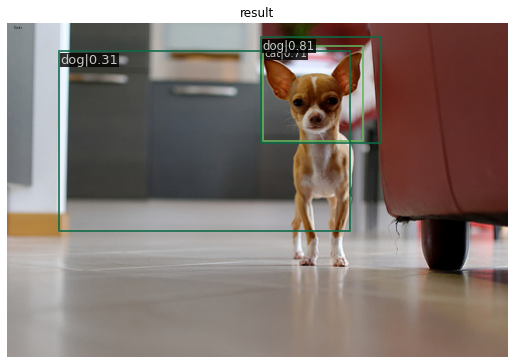

In [ ]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv

img = mmcv.imread('/content/images/Cats_Test1030.png')

model.cfg = cfg_inference
result = inference_detector(model, img)
show_result_pyplot(model, img, result)